In [1]:
import time

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# fix random seeds
rng_seed = 0
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

from xopt import Xopt
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.torch import LUMEModule

from utils import NegativeTransverseBeamSize, LinearMismatch
from utils import load_surrogate, running_max, create_vocs, print_runtime
from custom_mean import LinearCalibration

In [2]:
# load surrogate model and define objective
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)
surrogate_module = LUMEModule(surrogate, vocs.variable_names, ["sigma_x", "sigma_y"])
Objective = NegativeTransverseBeamSize
ground_truth = Objective(surrogate_module)

# Xopt evaluator function
def evaluate(input_dict):
    model_result = surrogate.evaluate(input_dict)
    obj_kwargs = {key:model_result[key] for key in surrogate_module.output_order}
    obj_value = Objective.function(**obj_kwargs).detach().item()
    return {objective_name: obj_value}

In [3]:
# define custom mean
x_dim = len(surrogate_module.feature_order)
y_dim = len(vocs.objective_names)

mismatch_scale = 0.3
x_shift = mismatch_scale * torch.rand(x_dim)
x_scale = torch.ones(x_dim) + mismatch_scale * torch.rand(x_dim)
y_shift = mismatch_scale * torch.rand(1)
y_scale = torch.ones(1) + mismatch_scale * torch.rand(1)

mismatched_gt = LinearMismatch(
    function=ground_truth,
    x_dim=x_dim,
    x_shift=x_shift,
    x_scale=x_scale,
    y_shift=y_shift,
    y_scale=y_scale,
)

custom_mean = LinearCalibration(
    mismatched_gt,
    x_dim=x_dim,
    y_dim=y_dim,
)

In [4]:
n_init = 3
inputs_init = pd.DataFrame(vocs.random_inputs(n=n_init, seed=rng_seed))
outputs = [evaluate(inputs_init.to_dict(orient="index")[i])[objective_name] for i in range(n_init)]
outputs_init = pd.DataFrame({objective_name: outputs})
data_init = pd.concat([inputs_init, outputs_init], axis=1)
data_init

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy
0,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201
1,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008
2,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977


In [5]:
# run BO
n_step = 50
t0 = time.time()

# Xopt definition
model_constructor = StandardModelConstructor(
    mean_modules={objective_name: custom_mean},
    trainable_mean_keys=[objective_name],
)
numerical_optimizer = LBFGSOptimizer(n_restarts=5, n_raw_samples=20)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    numerical_optimizer=numerical_optimizer,
)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs, data=data_init)

for i in range(n_step):
    # optimization step
    X.step()

# print runtime
print_runtime(t0, time.time())

Runtime: 10.73 min


In [6]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,negative_sigma_xy,xopt_runtime,xopt_error
1,0.315416,11.849845,0.218563,-0.008702,-0.007148,3.845480,-0.490601,3.625577,-2.844318,1.115676,-4.508010,-4.770960,4.084017,250.0,58000000.0,70000000.0,-2.673201,NaN,NaN
2,0.421819,4.680301,0.210919,-0.006318,0.009328,-20.211281,-4.794569,1.987560,-2.153845,2.887162,-2.112335,-3.202335,1.662885,250.0,58000000.0,70000000.0,-1.464008,NaN,NaN
3,0.488126,3.785076,0.222483,0.009938,-0.004593,-8.954229,9.007755,2.057821,-3.982130,3.097626,-0.082182,-1.481926,1.395637,250.0,58000000.0,70000000.0,-2.367977,NaN,NaN
4,0.500000,5.984350,0.203123,0.009988,0.009987,-1.470794,-24.707989,2.215011,-2.420396,6.999777,0.998352,-1.872800,4.946692,250.0,58000000.0,70000000.0,-3.987230,0.000572,False
5,0.500000,11.998570,0.256303,0.009993,0.009999,9.991752,8.407384,3.143895,-1.010512,1.179715,-2.651754,-4.035456,3.350122,250.0,58000000.0,70000000.0,-4.426486,0.000550,False
6,0.371462,11.998570,0.243443,-0.010000,-0.009999,-4.344254,-7.096639,3.998198,-2.923869,4.039594,-6.823027,-6.998418,1.588873,250.0,58000000.0,70000000.0,-2.870292,0.000521,False
7,0.402508,11.998570,0.236135,0.009984,0.009999,1.625128,-13.085509,2.006813,-1.947702,1.009173,-3.799107,-0.465975,3.123810,250.0,58000000.0,70000000.0,-1.344111,0.000580,False
8,0.500000,11.419292,0.236663,0.009993,0.009999,-24.998715,-24.999726,1.000040,-2.811529,6.999777,0.998352,-3.871876,6.998086,250.0,58000000.0,70000000.0,-1.911685,0.000594,False
9,0.210212,10.651181,0.256086,-0.007619,0.009999,-19.068559,-20.598193,2.049375,-1.610040,4.927649,-0.770576,-0.379153,4.461934,250.0,58000000.0,70000000.0,-4.126306,0.000655,False
10,0.500000,11.998570,0.256303,0.009993,0.009999,-16.057053,-24.999726,1.701717,-3.847929,6.999777,-1.635640,-4.802200,6.998086,250.0,58000000.0,70000000.0,-2.067476,0.000515,False


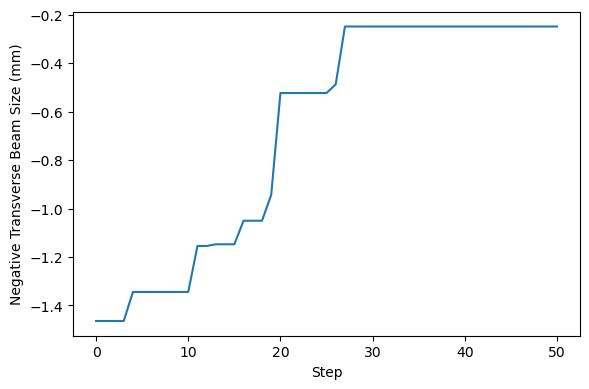

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
y = torch.from_numpy(X.data[objective_name].values)
ax.plot(x, running_max(y.squeeze())[n_init - 1:], "C0-")
ax.set_xlabel("Step")
ax.set_ylabel("{} ({})".format(ground_truth.name, ground_truth.unit))
fig.tight_layout()

In [8]:
# evaluate input calibration
custom_mean = X.generator.model.models[0].mean_module._model
if hasattr(custom_mean, "x_shift") and hasattr(custom_mean, "x_scale"):
    print("{:<5s} {:>10s} {:>10s} {:>10s} {:>10s}".format("x_dim", "x_shift", "learned", "x_scale", "learned"))
    for i in range(x_dim):
        x_shifts = (mismatched_gt.x_shift.detach()[i], -custom_mean.x_shift.detach()[i])
        x_scales = (mismatched_gt.x_scale.detach()[i], 1 / custom_mean.x_scale.detach()[i])
        print("{:<5d} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(i, *x_shifts, *x_scales))
        if i == x_dim - 1: print()

# evaluate output calibration
if hasattr(custom_mean, "y_shift") and hasattr(custom_mean, "y_scale"):
    print("{:<5s} {:>10s} {:>10s} {:>10s} {:>10s}".format("y_dim", "y_shift", "learned", "y_scale", "learned"))
    for i in range(y_dim):
        y_shifts = (mismatched_gt.y_shift.detach()[i], -custom_mean.y_shift.detach()[i])
        y_scales = (mismatched_gt.y_scale.detach()[i], 1 / custom_mean.y_scale.detach()[i])
        print("{:<5d} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(i, *y_shifts, *y_scales))

x_dim    x_shift    learned    x_scale    learned
0           0.15       0.20       1.05       1.10
1           0.23      -0.00       1.09       1.04
2           0.03      -0.00       1.16       1.04
3           0.04      -0.05       1.21       0.96
4           0.09      -0.06       1.24       1.09
5           0.19       0.06       1.05       1.06
6           0.15      -0.02       1.08       1.10
7           0.27      -0.07       1.20       1.15
8           0.14       0.01       1.27       0.99
9           0.19       0.20       1.12       1.05
10          0.10       0.12       1.26       1.07
11          0.12      -0.01       1.13       1.01
12          0.01       0.01       1.17       1.05

y_dim    y_shift    learned    y_scale    learned
0           0.29       0.13       1.01       1.04
